# Tasca: Pipelines, Grid Search i Text Mining

### Càrrega de llibreries

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

pd.set_option('display.max_columns', None)

### Lectura de la base de dades

In [3]:
dfl = pd.read_csv('diabetes.txt')
dfl.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# Informació de la base de dades: tipus de variables i compteig de nuls
dfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
# Compteig de la variable 'Outcome' (diabetes)
dfl.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

<span style='color:blue;font-size:16px'> Es decideix aplicar un SMOTE al pipeline per obtenir un nou dataframe amb els mateixos positius que negatius. </span>

## Exercici 1
__Agafa el conjunt de dades que vulguis i realitza un pipeline i un gridsearch aplicant l'algorisme de Random Forest.__

<span style='color:blue;font-size:16px'> L'objectiu es crear un model de classificació Random Forest per l'assignació de diabetes (variable objectiu) de diferents dones en base a uns atributs. </span>

<span style='color:blue;font-size:18px'> <b> Selecció de variables explicatives i variable objectiu </b> </span>

In [11]:
# Variable objectiu
y = dfl['Outcome']
# Predictors
X = dfl.drop(['Outcome'], axis = 1)
# LLista amb el nom dels predictors
X_list = list(X.columns)

<span style='color:blue;font-size:18px'> <b> Mostra d'entrenament i mostra de prova </b> </span>

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1234)
print("Dimensions de la mostra d'entrenament: ", X_train.shape)
print('Dimensions de la mostra de prova: ', X_test.shape)

Dimensions de la mostra d'entrenament:  (614, 8)
Dimensions de la mostra de prova:  (154, 8)


<span style='color:blue;font-size:18px'> <b> Definició del Pipeline </b> </span>

In [31]:
"""
Pas 1: Preprocessament - Estandarització
Pas 2: Aplicació de SMOTE
Pas 3: Entrenament amb el model Random Forest
"""
RF_pipeline = Pipeline([('preprocessament', StandardScaler()), 
                        ('smote', SMOTE(n_jobs=-1, random_state=3)),
                        ('random_forest', RandomForestClassifier(random_state=3))
                        ])

<span style='color:blue;font-size:18px'> <b> Gridsearch per l'afinació dels hiperparàmetres del model </b> </span>

In [34]:
# Selecció de diversos paràmetres i valors
tuned_parameters = {
    'random_forest__n_estimators': [50,100,150],
    'random_forest__criterion': ['gini','entropy'],
    'random_forest__max_features': ['auto', 'sqrt', 'log2'],
}

# Selecció de la mètrica a optimitzar
score='f1'

print("# Afinació dels hiper-paràmetres de %s" % score)
print()
clf_RF = GridSearchCV(estimator = RF_pipeline, param_grid = tuned_parameters, cv=10, scoring='%s' % score, n_jobs= -1)
clf_RF.fit(X_train, y_train)
    
print("Millors paràmetres trobats:")
print()
print(clf_RF.best_params_)

# Afinació dels hiper-paràmetres de f1

Millors paràmetres trobats:

{'random_forest__criterion': 'gini', 'random_forest__max_features': 'log2', 'random_forest__n_estimators': 150}


<span style='color:blue;font-size:18px'> <b> Avaluació del model </b> </span>

In [36]:
pred_test_RF = clf_RF.predict(X_test)
print(metrics.classification_report(y_test, pred_test_RF))
print("Accuracy score: ", metrics.accuracy_score(y_test, pred_test_RF))
print("AUC: ", metrics.roc_auc_score(y_test, pred_test_RF))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80        99
           1       0.65      0.60      0.62        55

    accuracy                           0.74       154
   macro avg       0.72      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154

Accuracy score:  0.7402597402597403
AUC:  0.7090909090909091


<span style='color:blue;font-size:16px'> Es tracta d'un model que no classifica gaire bé. </span>

## Exercici 2
__Agafa un text en anglès que vulguis, i calcula'n la freqüència de les paraules.__

In [52]:
# Separació del text per paraules i simbols
text = """Statistics is the discipline that concerns the collection, organization, analysis, interpretation, and presentation of data.
        In applying statistics to a scientific, industrial, or social problem, it is conventional to begin with a statistical population 
        or a statistical model to be studied. Populations can be diverse groups of people or objects such as 'all people living in a country' or 'every atom composing a crystal'. 
        Statistics deals with every aspect of data, including the planning of data collection in terms of the design of surveys and experiments."""
token_text = word_tokenize(text)

In [53]:
# Primeres 20 paraules
print(token_text[:20])

['Statistics', 'is', 'the', 'discipline', 'that', 'concerns', 'the', 'collection', ',', 'organization', ',', 'analysis', ',', 'interpretation', ',', 'and', 'presentation', 'of', 'data', '.']


In [54]:
# Indica elnombre de paraules úniques i el total de paraules
fdist = FreqDist(token_text)
print(fdist)

<FreqDist with 61 samples and 100 outcomes>


In [55]:
# Top 5 paraules més repetides
fdist.most_common(5)

[(',', 8), ('of', 6), ('a', 5), ('the', 4), ('.', 4)]

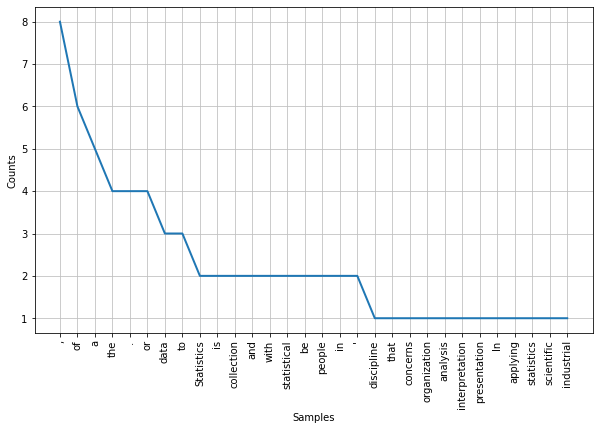

In [56]:
# Gràfic de distribució de freqüència
plt.figure(figsize=(10,6))
fdist.plot(30,cumulative=False)
plt.show()

<span style='color:blue;font-size:16px'> La paraula amb sentit que més apareix és 'data' (3 cops), seguida de 'Statistics' (2 cops), etc. </span>

## Exercici 3
__Treu les stopwords i realitza stemming al teu conjunt de dades.__

In [57]:
# Llista de paraules buides de l'anglès
stop_words = set(stopwords.words("english"))
print(stop_words)

{'again', 'an', 've', 'on', "that'll", 'above', 'between', 'too', "weren't", 'what', 'then', 'further', 'most', 're', 'yours', 'these', 'some', 'aren', 'am', 's', 'itself', 'but', 'through', 'shouldn', 'which', 'in', 'have', 'them', 'under', 'other', 'weren', 'below', 'his', 'won', 'do', "hasn't", "couldn't", 'out', 'to', 'this', "mightn't", 'its', 'y', 'm', 'him', "she's", 'is', 'it', 'don', 'how', 'because', 'just', "needn't", 'when', 'at', "it's", 'been', 'ma', 'had', 'own', 'has', 'does', 'if', 'be', 'once', 'our', 'why', 'no', 'hadn', 'as', 'during', 'few', 'haven', "didn't", 'a', 'my', 'each', 'until', 'any', 'me', "you'd", 'wasn', "won't", 'ours', 'or', 'will', 'those', "you've", 'the', 'ourselves', 'all', 'shan', 'isn', 'myself', 'more', 'very', "don't", 'off', 'wouldn', 'by', 'same', 'i', 'there', 'only', 'while', 'before', 'your', 'with', 'over', 'both', 'mightn', "hadn't", 'themselves', 'for', 'about', 'should', 'yourself', 'he', 'doing', "shouldn't", "wasn't", "isn't", 'mus

In [58]:
# S'eliminen les stopwords del text
text_sw=[]
for w in token_text:
    if w not in stop_words:
        text_sw.append(w)
print("Text tokenitzat sense stopwords: ", text_sw)

Text tokenitzat sense stopwords:  ['Statistics', 'discipline', 'concerns', 'collection', ',', 'organization', ',', 'analysis', ',', 'interpretation', ',', 'presentation', 'data', '.', 'In', 'applying', 'statistics', 'scientific', ',', 'industrial', ',', 'social', 'problem', ',', 'conventional', 'begin', 'statistical', 'population', 'statistical', 'model', 'studied', '.', 'Populations', 'diverse', 'groups', 'people', 'objects', "'all", 'people', 'living', 'country', "'", "'every", 'atom', 'composing', 'crystal', "'", '.', 'Statistics', 'deals', 'every', 'aspect', 'data', ',', 'including', 'planning', 'data', 'collection', 'terms', 'design', 'surveys', 'experiments', '.']


In [59]:
# Aplicació del Stemming
ps = PorterStemmer()

stemmed_words=[]
for w in text_sw:
    stemmed_words.append(ps.stem(w))

print("Filtered Sentence:", text_sw)
print()
print("Stemmed Sentence:", stemmed_words)

Filtered Sentence: ['Statistics', 'discipline', 'concerns', 'collection', ',', 'organization', ',', 'analysis', ',', 'interpretation', ',', 'presentation', 'data', '.', 'In', 'applying', 'statistics', 'scientific', ',', 'industrial', ',', 'social', 'problem', ',', 'conventional', 'begin', 'statistical', 'population', 'statistical', 'model', 'studied', '.', 'Populations', 'diverse', 'groups', 'people', 'objects', "'all", 'people', 'living', 'country', "'", "'every", 'atom', 'composing', 'crystal', "'", '.', 'Statistics', 'deals', 'every', 'aspect', 'data', ',', 'including', 'planning', 'data', 'collection', 'terms', 'design', 'surveys', 'experiments', '.']

Stemmed Sentence: ['statist', 'disciplin', 'concern', 'collect', ',', 'organ', ',', 'analysi', ',', 'interpret', ',', 'present', 'data', '.', 'In', 'appli', 'statist', 'scientif', ',', 'industri', ',', 'social', 'problem', ',', 'convent', 'begin', 'statist', 'popul', 'statist', 'model', 'studi', '.', 'popul', 'divers', 'group', 'peop

## Exercici 4
__Realitza sentiment analysis al teu conjunt de dades.__

<span style='color:blue;font-size:16px'> Per realitzar aquest exercici es treballa amb una nova base de dades </span>

<span style='color:blue;font-size:18px'> <b> Lectura de la base de dades </b> </span>

In [62]:
sent_df = pd.read_csv('reviews_sentiment.csv', sep=';')
sent_df.head()

,Review Title,Review Text,wordcount,titleSentiment,textSentiment,Star Rating,sentimentValue
0,Sin conexión,Hola desde hace algo más de un mes me pone sin...,23,negative,negative,1,-0.486389
1,faltan cosas,Han mejorado la apariencia pero no,20,negative,negative,1,-0.586187
2,Es muy buena lo recomiendo,Andres e puto amoooo,4,NaN,negative,1,-0.602240
3,Version antigua,Me gustana mas la version anterior esta es mas...,17,NaN,negative,1,-0.616271
4,Esta bien,Sin ser la biblia.... Esta bien,6,negative,negative,1,-0.651784


<span style='color:blue;font-size:18px'> <b> Descriptius i gràfics </b> </span>

In [63]:
# Información sobre la base de datos
sent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Review Title    257 non-null    object 
 1   Review Text     257 non-null    object 
 2   wordcount       257 non-null    int64  
 3   titleSentiment  231 non-null    object 
 4   textSentiment   257 non-null    object 
 5   Star Rating     257 non-null    int64  
 6   sentimentValue  257 non-null    float64
dtypes: float64(1), int64(2), object(4)
memory usage: 14.2+ KB


In [65]:
# Compteig de 'Star Rating'
sent_df['Star Rating'].value_counts()

5    88
3    78
1    37
4    30
2    24
Name: Star Rating, dtype: int64

<span style='color:blue;font-size:16px'> Es té cinc puntuacions possibles. La més baixa és 1 i la més alta és 5 </span>

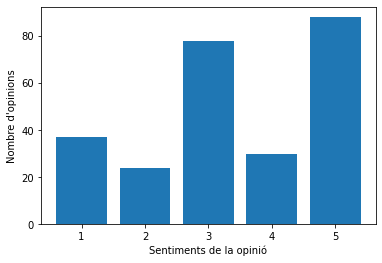

In [67]:
# Barplot de Star Rating
SR_count = sent_df.groupby('Star Rating').count()
plt.bar(SR_count.index.values, SR_count['Review Text'])
plt.xlabel('Sentiments de la opinió')
plt.ylabel("Nombre d'opinions")
plt.show()

<span style='color:blue;font-size:16px'> Hi ha més opinions positives que negatives (considerant 3 com a neutre) </span>

<span style='color:blue;font-size:20px'> <b> Métode Bag of Words </b> </span>

In [74]:
# Es treuen els element no desitjats (símbols, números, etc)
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words=set(stopwords.words("spanish")),ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(sent_df['Review Text'])

In [77]:
# Mostra d'entrenament i mostra de prova
X_train, X_test, y_train, y_test = train_test_split(text_counts, sent_df['Star Rating'], test_size=0.2, random_state=3)
X_train.shape, X_test.shape

((205, 411), (52, 411))

In [78]:
# Generació del model utilitzant Multinomial Naive Bayes i avaluació
MNV_model = MultinomialNB().fit(X_train, y_train)
predicted= MNV_model.predict(X_test)
print("MultinomialNB Accuracy: ", metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy:  0.3076923076923077


<span style='color:blue;font-size:16px'> Amb aquest métode les prediccions són dolentes </span>

<span style='color:blue;font-size:20px'> <b> Métode TF-IDF </b> </span>

In [81]:
# Es normalitza la matriu de termes
tf = TfidfVectorizer()
text_tf = tf.fit_transform(sent_df['Review Text'])

In [84]:
# Muestra de entrenamiento y muestra de prueba
X_train, X_test, y_train, y_test = train_test_split(text_tf, sent_df['Star Rating'], test_size=0.2, random_state=3)
X_train.shape, X_test.shape

((205, 468), (52, 468))

In [85]:
# Generació del model utilitzant Multinomial Naive Bayes i avaluació
MNV_model_2 = MultinomialNB().fit(X_train, y_train)
predicted_2 = MNV_model_2.predict(X_test)
print("MultinomialNB Accuracy: ", metrics.accuracy_score(y_test, predicted_2))

MultinomialNB Accuracy:  0.36538461538461536


<span style='color:blue;font-size:16px'> Amb aquest métode les prediccions són dolentes, però millor que en el cas anterior </span>